Step 1: Upload the Data and perform the initial inspection
- Target Value: 'TOT_PAID' and date column: 'ACC_MONTH'
- Feature Columns: 'EST_COST', 'NBR_CASE' = 'NBR_KEY_CASE' + 'NBR_OTHER'
due to the mathematical equation between case related fields only one of them along with the 'EST_COST' has the potential to be a valid regressor

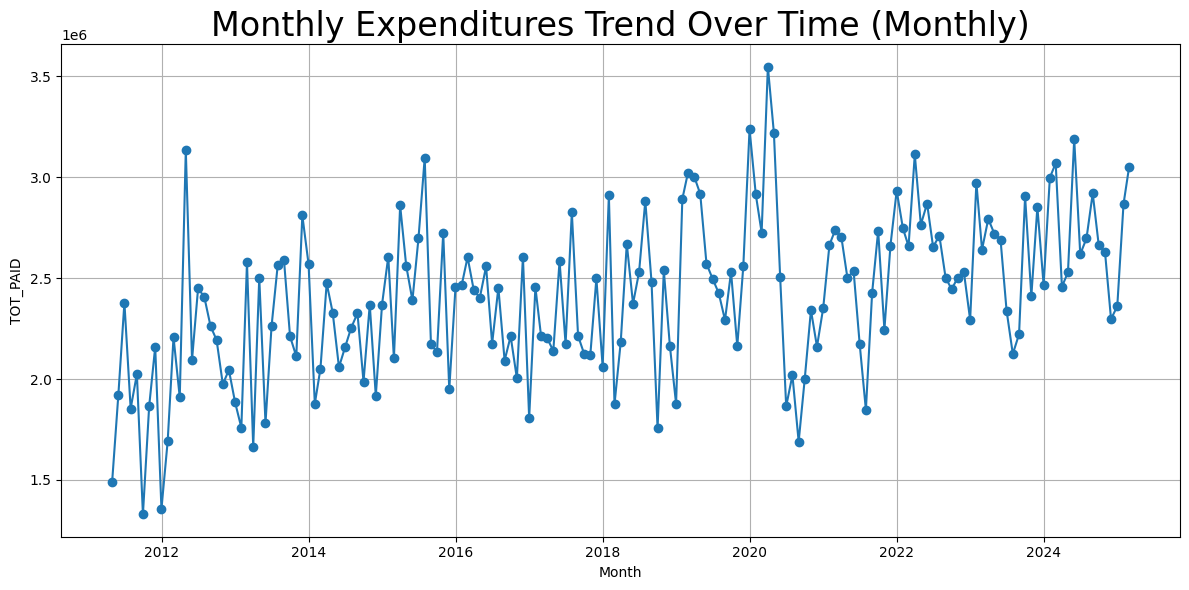

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.plot import plot_components_plotly

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.arima.model import ARIMA

#######################################################################################################
# set the random seed for reproducibility
import random
import os

seed_value = 42

# Set random seed for Python, NumPy, TensorFlow
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Set environment variable to control TF deterministic ops
os.environ['TF_DETERMINISTIC_OPS'] = '1'
####################################################################################################



# Load Dataset
data = pd.read_csv("C:/GitHub/Machine-Learning/data/Payment Data.csv")
#data = pd.read_csv("C:/Users/Parsazh/Documents/GitHub/Machine-Learning/data/Payment Data.csv")

# dataset preprocess
data['ACC_MONTH'] = pd.to_datetime(data['ACC_MONTH'])
df = data[['ACC_MONTH', 'TOT_PAID', 'EST_COST', 'NBR_CASE', 'NBR_KEY_CASE','NBR_OTHER']].dropna()
df = data.sort_values(by='ACC_MONTH')


# Plot the trend of TOT_PAID
plt.figure(figsize=(12, 6))
plt.plot(df['ACC_MONTH'], df['TOT_PAID'], marker='o', linestyle='-')
plt.title('Monthly Expenditures Trend Over Time (Monthly)',fontsize=24)
plt.xlabel('Month')
plt.ylabel('TOT_PAID')
plt.grid(True)
plt.tight_layout()
plt.show()


Step 2: Correlation and Lag analysis, using statistical test: Garnger Casuality

Calculating the correlation between the target value and potential regressors, running a lag correlation analysis and testing the best lag’s significance by Granger Casualty Test and finalizing the potential regressors and their lag in the model 

\Pearson Correlation Coefficients:
              NBR_CASE  NBR_OTHER  NBR_KEY_CASE
NBR_CASE         1.000      0.919         0.604
NBR_OTHER        0.919      1.000         0.241
NBR_KEY_CASE     0.604      0.241         1.000

P-values of Pearson Correlation Tests:
              NBR_CASE  NBR_OTHER  NBR_KEY_CASE
NBR_CASE           0.0     0.0000        0.0000
NBR_OTHER          0.0     0.0000        0.0017
NBR_KEY_CASE       0.0     0.0017        0.0000


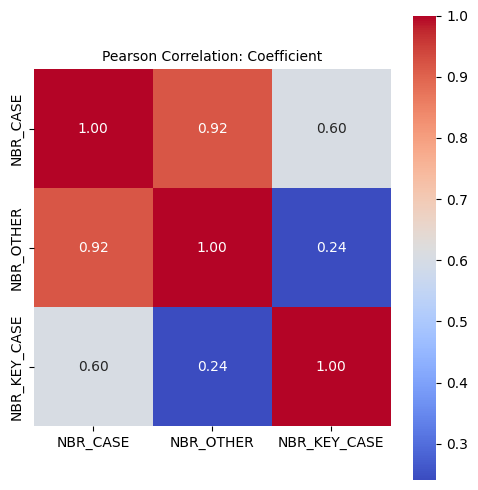

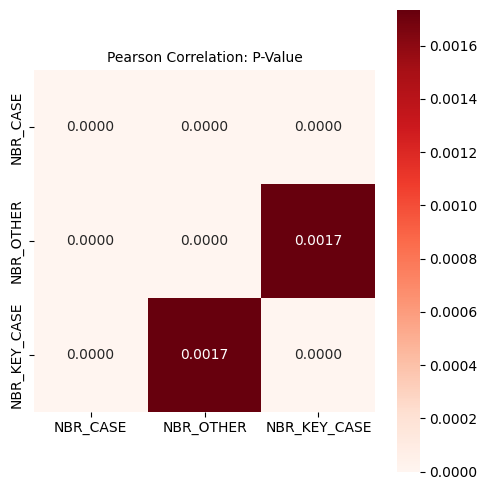

In [5]:
2.1 #Correlation Analysis

from scipy.stats import pearsonr


# Select numeric features for correlation
features = ['NBR_CASE', 'NBR_OTHER', 'NBR_KEY_CASE']
df_corr = df[features].dropna()

# Initialize empty DataFrames for correlations and p-values
corr_matrix = pd.DataFrame(index=features, columns=features, dtype=float)
pval_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

# Compute Pearson correlation and p-values
for col1 in features:
    for col2 in features:
        corr, pval = pearsonr(df_corr[col1], df_corr[col2])
        corr_matrix.loc[col1, col2] = corr
        pval_matrix.loc[col1, col2] = pval

# Display the correlation matrix
print("\Pearson Correlation Coefficients:")
print(corr_matrix.round(3))

# Display the p-value matrix
print("\nP-values of Pearson Correlation Tests:")
print(pval_matrix.round(4))

# Optional: Plot correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson Correlation: Coefficient",fontsize=10)
plt.tight_layout()
plt.show()

# Optional: Plot p-values
plt.figure(figsize=(5, 5))
sns.heatmap(pval_matrix.astype(float), annot=True, fmt=".4f", cmap="Reds", square=True)
plt.title("Pearson Correlation: P-Value",fontsize=10)
plt.tight_layout()
plt.show()


# output: As we expected: NBR_CASE has significant intercorrelation with NBR_KEY_CASE(0.6) and NBR_OTHER (0.92) (NBR_CASE = NBR_KEY_CASE + NBR_OTHER)
# we can skip this stage as it does not have much to add to this analysis

Best Lag for EST_COST: 12.0 months (Correlation = 0.70)


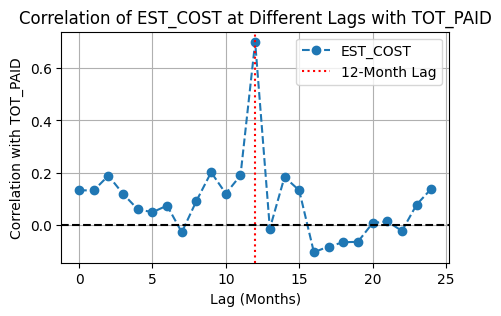

Best Lag for NBR_KEY_CASE: 12.0 months (Correlation = 0.34)


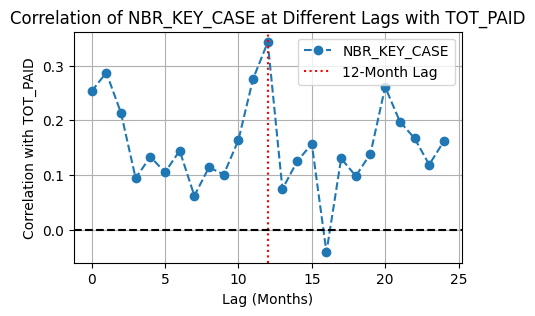

Best Lag for NBR_CASE: 12.0 months (Correlation = 0.53)


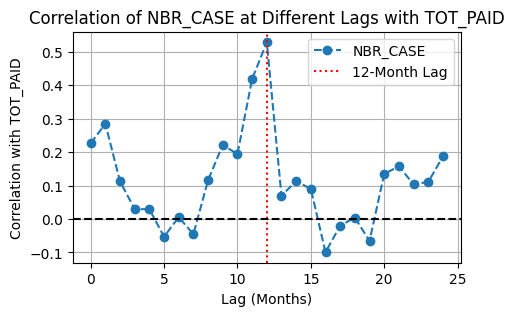

Best Lag for NBR_OTHER: 12.0 months (Correlation = 0.47)


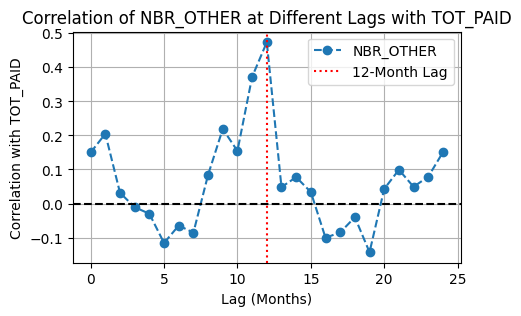


Running Granger Causality Test (Does EST_COST Granger-cause TOT_PAID?)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4384  , p=0.2321  , df_denom=163, df_num=1
ssr based chi2 test:   chi2=1.4649  , p=0.2262  , df=1
likelihood ratio test: chi2=1.4584  , p=0.2272  , df=1
parameter F test:         F=1.4384  , p=0.2321  , df_denom=163, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3848  , p=0.0954  , df_denom=160, df_num=2
ssr based chi2 test:   chi2=4.9187  , p=0.0855  , df=2
likelihood ratio test: chi2=4.8468  , p=0.0886  , df=2
parameter F test:         F=2.3848  , p=0.0954  , df_denom=160, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2312  , p=0.3003  , df_denom=157, df_num=3
ssr based chi2 test:   chi2=3.8583  , p=0.2772  , df=3
likelihood ratio test: chi2=3.8136  , p=0.2823  , df=3
parameter F test:         F=1.2312  , p=0.3003  , df_denom=157, df_num=3

Granger Causality
num

In [7]:
# 2.2 LAG Analysis:
import warnings
# Function to test lag correlation analysis
def test_lag_correlation(target, regressor, max_lag=24):
    correlations = {}
    
    for lag in range(0, max_lag + 1):
        with warnings.catch_warnings():
             warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
        df[f'{regressor}_LAG_{lag}'] = df[regressor].shift(lag)
        correlations[lag] = df[[target, f'{regressor}_LAG_{lag}']].corr().iloc[0, 1]
    
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['Lag (Months)', 'Correlation'])
    best_lag = correlation_df.iloc[correlation_df['Correlation'].abs().idxmax()]
    
    print(f"Best Lag for {regressor}: {best_lag['Lag (Months)']} months (Correlation = {best_lag['Correlation']:.2f})")
    
    plt.figure(figsize=(5, 3))
    plt.plot(correlation_df['Lag (Months)'], correlation_df['Correlation'], marker='o', linestyle='dashed', label=regressor)
    plt.axvline(x=12, color='red', linestyle='dotted', label="12-Month Lag")
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.xlabel("Lag (Months)")
    plt.ylabel("Correlation with TOT_PAID")
    plt.title(f"Correlation of {regressor} at Different Lags with TOT_PAID")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_lag


# Test lag correlation for EST_COST, NBR_KEY_CASE, NBR_OTHER and NBR_CASE
best_est_cost_lag = test_lag_correlation('TOT_PAID', 'EST_COST')
best_key_case_lag = test_lag_correlation('TOT_PAID', 'NBR_KEY_CASE')
best_case_lag = test_lag_correlation('TOT_PAID', 'NBR_CASE')
best_other_case_lag = test_lag_correlation('TOT_PAID', 'NBR_OTHER')

# Run Granger Causality Test for each regressor
print("\nRunning Granger Causality Test (Does EST_COST Granger-cause TOT_PAID?)")
granger_budget = grangercausalitytests(df[['TOT_PAID', 'EST_COST']].dropna(), best_est_cost_lag['Lag (Months)'])

print("\nRunning Granger Causality Test (Does NBR_KEY_CASE Granger-cause TOT_PAID?)")
granger_murder = grangercausalitytests(df[['TOT_PAID', 'NBR_KEY_CASE']].dropna(), best_key_case_lag['Lag (Months)'])

print("\nRunning Granger Causality Test (Does NBR_CASE Granger-cause TOT_PAID?)")
granger_case = grangercausalitytests(df[['TOT_PAID', 'NBR_CASE']].dropna(), best_case_lag['Lag (Months)'])

print("\nRunning Granger Causality Test (Does NBR_OTHER Granger-cause TOT_PAID?)")
granger_case = grangercausalitytests(df[['TOT_PAID', 'NBR_OTHER']].dropna(), best_other_case_lag['Lag (Months)'])

#Output: there is a significant correlation btweent the target value and features at lag 12 which is statistically confirmed by Granger Cause test.
# It means that features are Granger Causing TOT_PAID at lag 12 
# What does it mean? The value of Nbr of Cases and also Est Cost after 12 months (lag 12) shows a siginificant impact (correlation) on Total Expenditure



 Explained Variance Ratio per Principal Component:
PC1: 0.6934
PC2: 0.1955
PC3: 0.1111
PC4: 0.0000


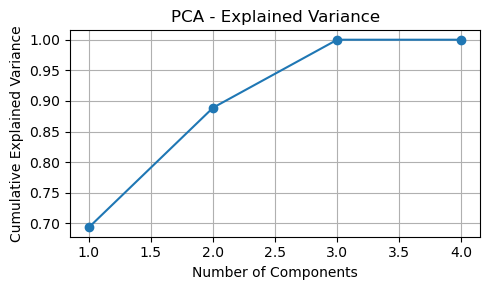


 Feature Importance Based on PCA Loadings:
              Average Importance
NBR_OTHER               0.489133
NBR_CASE                0.430779
NBR_KEY_CASE            0.427243
EST_COST                0.352642


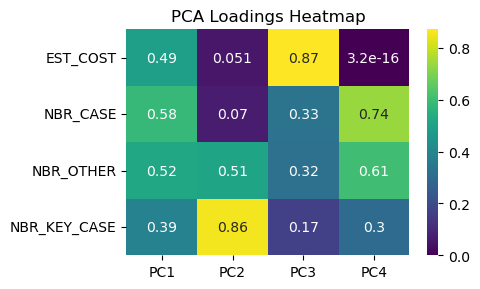

In [11]:
#2.3 PCA analysis

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

######### set the random seed for reproducibility
pca = PCA(n_components=2, svd_solver='full', random_state=seed_value)



# Standardize the features
features = ['EST_COST', 'NBR_CASE', 'NBR_OTHER', 'NBR_KEY_CASE']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_
print("\n Explained Variance Ratio per Principal Component:")
for i, var in enumerate(explained_var):
    print(f"PC{i+1}: {var:.4f}")

# Plot cumulative variance
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance per component (absolute values of loadings)
loadings = pd.DataFrame(
    abs(pca.components_.T),
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Optional: Average importance across all components
loadings['Average Importance'] = loadings.mean(axis=1)
loadings_sorted = loadings.sort_values(by='Average Importance', ascending=False)

print("\n Feature Importance Based on PCA Loadings:")
print(loadings_sorted[['Average Importance']])

# Optional: Heatmap of PCA loadings
plt.figure(figsize=(5, 3))
sns.heatmap(loadings.drop(columns='Average Importance'), annot=True, cmap='viridis')
plt.title("PCA Loadings Heatmap")
plt.tight_layout()
plt.show()

#output: the most important feature factor in this analysis is: NBR_OTHER and the 2nd (if applicable)would be EST_COST.
# because of the math equation between NBR_CASE, NBR_KEY_OTHER and NBR_OTHER

#Conclustion: at the end of step 2 we can conclude that: Target value is 'TOT_PAID', Features at lag 12: 'NBR_OTHER' and 'EST_COST' 
# Therefore, we can start the Model Fitting at the next step

Step 3: Model Fitting and measuring model's accuracy by RMSE, MAE, MAPE

Testing various time series methods and measuring the accuracy of each method. Selecting the best method minimum MAPE as the most accurate method


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

Searching best ARIMA parameters based on AIC


10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:57 - cmdstanpy - INFO - Chain [1] done processing


 Best ARIMA order: (3, 1, 3) with AIC: 3852.29

--- Forecast Accuracy Comparison ---
     Model       RMSE        MAE  MAPE
0  Prophet  237621.58  192919.17  6.97
1     LSTM  256232.59  231365.64  8.39
2    ARIMA  347567.08  284211.08  9.95

 Best Model Based on RMSE: Prophet


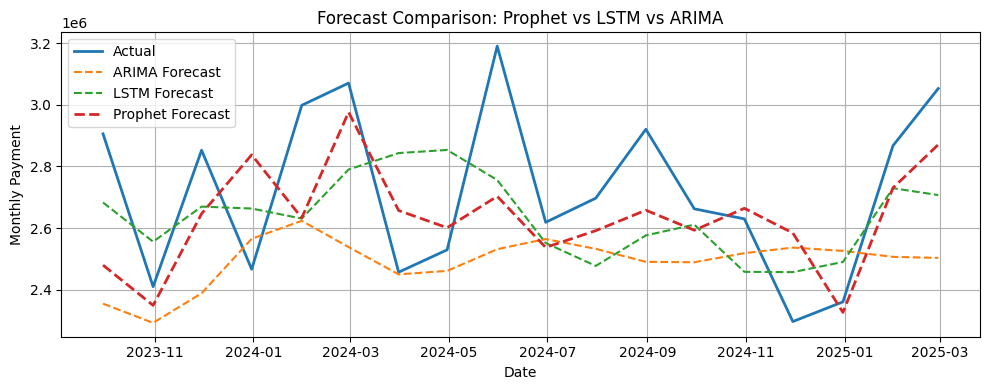


The components of the best model: Prophet


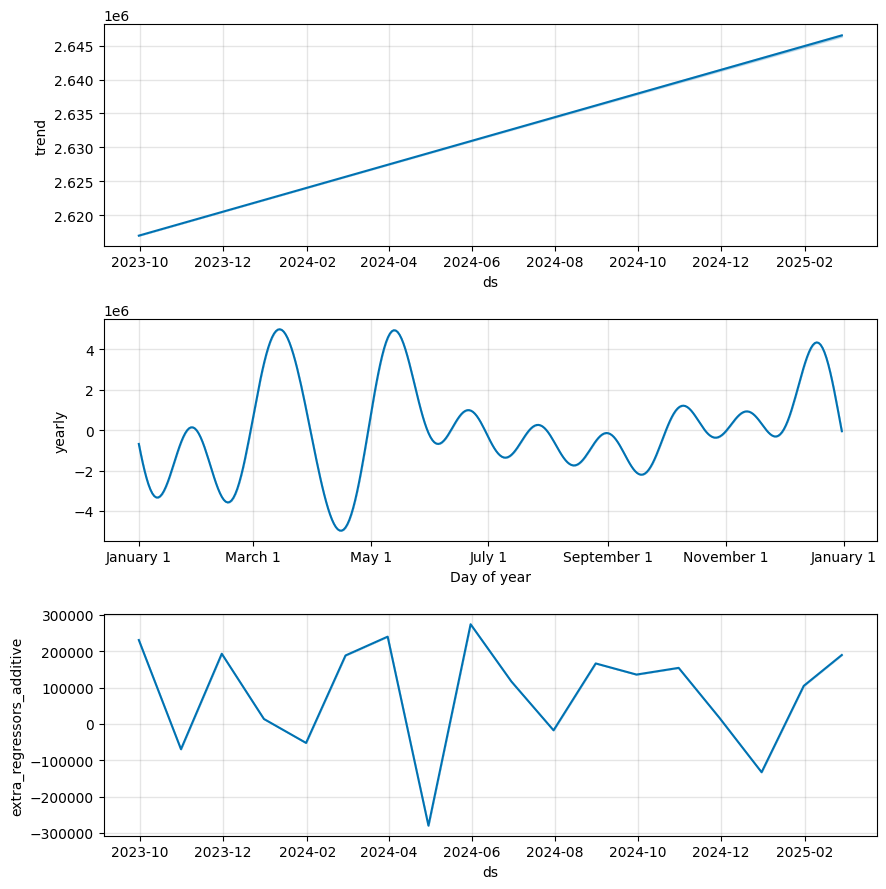

In [8]:
# Model Search: Prophet, ARIMA, LSTM 

# 1 - Prophet Method: it includes seasonality effect, sets the change point to 0.2 (partial sensitivity toward fluctuations) and includes regressors: PC1 and PC2
# 2 - LSTM: use adam optimizer and mse and the loss function, activation is relu since we have no negative value in target value, set 12 learning step before any prediction,
    # includes regressors PC1 and PC2
# 3 - ARIMA: fits an ARIMA model on targert value trend by searching for the minimum AIC among all the possible models with parameters (0,4) for P and Q 
    # and D (differential factor) from 0 to 2


import warnings
warnings.filterwarnings("ignore")


# 3.1 prep the dataset - re read from the original dataset to prevent any error from potential chages to df in previous steps
df = data[['ACC_MONTH', 'TOT_PAID', 'EST_COST', 'NBR_CASE', 'NBR_KEY_CASE','NBR_OTHER']].dropna()
df['ACC_MONTH'] = pd.to_datetime(df['ACC_MONTH'])
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
df = df.sort_values('ds').reset_index(drop=True)

# --- Lagged Regressors ---
lag = 12
regressors = ['EST_COST', 'NBR_OTHER','NBR_CASE','NBR_KEY_CASE']
for reg in regressors:
    df[f'{reg}_lag{lag}'] = df[reg].shift(lag)
df_model = df.dropna().copy().reset_index(drop=True)

# --- PCA on Lagged Regressors ---
lagged_features = [f'{reg}_lag{lag}' for reg in regressors]
X_lagged = StandardScaler().fit_transform(df_model[lagged_features])
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_lagged)
df_model['PC1'] = pcs[:, 0]
df_model['PC2'] = pcs[:, 1]

#3.2 Fitting three time series models and measuing their accuracy for comparison


################## 1. LSTM Model ##########################

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_all = feature_scaler.fit_transform(df_model[['PC1', 'PC2']])
y_all = target_scaler.fit_transform(df_model[['TOT_PAID']])

time_steps = 12 #12 step learning sequence because we know our data has annual seasonality. 
X_seq, y_seq = [], []
for i in range(len(X_all) - time_steps):
    X_seq.append(X_all[i:i+time_steps])
    y_seq.append(y_all[i+time_steps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

split = len(X_seq) - 18
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
# we use sequential layering here because we want one layer output to be considered as the next layer's input as a classing time series forecasting trend
# we use relue becuase our target value data are expenditures and above zero
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dense(1)
])

# we use Adam optimizer for faster processing
# step size = 0.001 as the learning rate which is good enough for this model search task
# and use Mean Square Error mae as the loss funtion in our sequential LSTM model
# verbose is set to 0 to suppress the training logs

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 
model.fit(X_train, y_train, epochs=100, verbose=0, shuffle=False)

y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test)

lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm_mae = mean_absolute_error(y_test_inv, y_pred_inv)
lstm_mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100


################# 2. ARIMA Model with AIC Optimization #################

# defines tha last 1 and 1/2 year data for the testing the model
arima_train = df_model['TOT_PAID'][:-18]
arima_test = df_model['TOT_PAID'][-18:]

# Grid search for best ARIMA order we use Akaike Information Criterion (AIC) to search for the best model with minimum AIC
best_aic = np.inf
best_order = None
best_model = None

print("\nSearching best ARIMA parameters based on AIC")
# reasonable range for parameters in ARIMA model is less than 4

for p in range(0, 4):                           
    for d in range(0, 2):               # Differential parameter range is usually set to half of the max of P or Q which are 4 here
        for q in range(0, 4):
            try:
                model = ARIMA(arima_train, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
            except:
                continue

print(f" Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

# Forecast using best model
arima_forecast = best_model.forecast(steps=18)

arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_forecast))
arima_mae = mean_absolute_error(arima_test, arima_forecast)
arima_mape = np.mean(np.abs((arima_test - arima_forecast) / arima_test)) * 100

################# 3. Prophet Model ############################

train = df_model[:-18]
test = df_model[-18:]

prophet_model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.2)
prophet_model.add_regressor('PC1')
prophet_model.add_regressor('PC2')
prophet_model.fit(train[['ds', 'y', 'PC1', 'PC2']])
forecast_test = prophet_model.predict(test[['ds', 'PC1', 'PC2']])

# Prophet evaluation
prophet_rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
prophet_mae = mean_absolute_error(test['y'], forecast_test['yhat'])

actual = test['y'].values
predicted = forecast_test['yhat'].values
nonzero_mask = actual != 0
actual_nonzero = actual[nonzero_mask]
predicted_nonzero = predicted[nonzero_mask]
prophet_mape = np.mean(np.abs((actual_nonzero - predicted_nonzero) / actual_nonzero)) * 100 if len(actual_nonzero) > 0 else np.nan

############ Compare Models ###################

results = pd.DataFrame({
    'Model': ['Prophet', 'LSTM', 'ARIMA'],
    'RMSE': [prophet_rmse, lstm_rmse, arima_rmse],
    'MAE': [prophet_mae, lstm_mae, arima_mae],
    'MAPE': [prophet_mape, lstm_mape, arima_mape]
    
})

best_model = results.loc[results['MAPE'].idxmin()]

print("\n--- Forecast Accuracy Comparison ---")
print(results.round(2))
print(f"\n Best Model Based on RMSE: {best_model['Model']}")

#3.3 ploting the results for comparison


test_dates = df_model['ds'][-18:].reset_index(drop=True)

plt.figure(figsize=(10, 4))
plt.plot(test_dates, arima_test.values, label='Actual', linewidth=2)
plt.plot(test_dates, arima_forecast.values, label='ARIMA Forecast', linestyle='--')
plt.plot(test_dates, y_pred_inv.flatten(), label='LSTM Forecast', linestyle='--')
plt.plot(test_dates, forecast_test['yhat'].values, label='Prophet Forecast', linestyle='--',linewidth = 2)

plt.xlabel("Date")
plt.ylabel("Monthly Payment")
plt.title("Forecast Comparison: Prophet vs LSTM vs ARIMA")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.xticks(rotation=45)
plt.show()


# 3.3 plotting the component of the most accurate model
print("\nThe components of the best model: Prophet")
fig = prophet_model.plot_components(forecast_test)


#output: the model's accuracy is in a very good level so we have good confindece about its performance for future data
# Prophet plot component also shows that the model has a steady increasing trend, complex seasonality effect and decent influence of regressors (PC1 & PC2)




Step 4: Forecasting 18 months to the future based on the best fitted model: prophet_model

Forecasting regressors for 18 months future to be used for forecasting 18 months future total expenditures 

In [13]:
#### --- Forecast 18 Future Months of TOT_PAID Using Prophet model created in previous cell ---

# Part 4.1: Forecast each regressor using Prophet
future_regressors = {}
forecast_horizon = 6  # Only need 6 months because we're using lag=12

for reg in regressors:
    df_reg = df_model[['ds', reg]].rename(columns={reg: 'y'})
    reg_model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.2)
    reg_model.fit(df_reg)

    future_dates = reg_model.make_future_dataframe(periods=forecast_horizon + lag, freq='ME')
    reg_forecast = reg_model.predict(future_dates)
    future_regressors[reg] = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': f'{reg}_forecast'})

# Merge forecasted regressors
future_df = future_regressors[regressors[0]].copy()
for reg in regressors[1:]:
    future_df = future_df.merge(future_regressors[reg], on='ds')

# Create lag-12 features we repeat this setp to prevent errors
for reg in regressors:
    future_df[f'{reg}_lag12'] = future_df[f'{reg}_forecast'].shift(12)

future_df = future_df.dropna().reset_index(drop=True)

# Use scaler and PCA trained on lagged features
lagged_features = [f'{reg}_lag{lag}' for reg in regressors]  # ['EST_COST_lag12', 'NBR_OTHER_lag12']
X_train_lagged = df_model[lagged_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_lagged)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add back PC1 and PC2 to training df (in case not done earlier)
df_model['PC1'] = X_pca[:, 0]
df_model['PC2'] = X_pca[:, 1]

# Transform future data using same scaler and PCA
future_X = future_df[lagged_features]
future_X_scaled = scaler.transform(future_X)
future_X_pca = pca.transform(future_X_scaled)
future_df['PC1'] = future_X_pca[:, 0]
future_df['PC2'] = future_X_pca[:, 1]

# Part 4.2 Prepare future input for Prophet
last_actual_date = df_model['ds'].max()
future_input = future_df[future_df['ds'] > last_actual_date][['ds', 'PC1', 'PC2']].head(18)


# Part 4.3: Forecast 18 months to the future
future_forecast = prophet_model.predict(future_input)


print(" Forecasted TOT_PAID for the Next 18 Months:")
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_string(index=False))





11:29:28 - cmdstanpy - INFO - Chain [1] start processing
11:29:28 - cmdstanpy - INFO - Chain [1] done processing
11:29:28 - cmdstanpy - INFO - Chain [1] start processing
11:29:28 - cmdstanpy - INFO - Chain [1] done processing


 Forecasted TOT_PAID for the Next 18 Months:
        ds         yhat   yhat_lower   yhat_upper
2025-03-31 2.838407e+06 2.595101e+06 3.098330e+06
2025-04-30 3.074529e+06 2.817698e+06 3.338342e+06
2025-05-31 2.695801e+06 2.421001e+06 2.975955e+06
2025-06-30 2.711288e+06 2.438524e+06 2.949698e+06
2025-07-31 2.784153e+06 2.503778e+06 3.074567e+06
2025-08-31 2.620044e+06 2.363315e+06 2.887435e+06
2025-09-30 2.595972e+06 2.329141e+06 2.853290e+06
2025-10-31 2.587908e+06 2.309733e+06 2.864261e+06
2025-11-30 2.803082e+06 2.555834e+06 3.086591e+06
2025-12-31 2.692523e+06 2.412070e+06 2.961473e+06
2026-01-31 3.014891e+06 2.759775e+06 3.284778e+06
2026-02-28 2.828784e+06 2.588894e+06 3.099354e+06
2026-03-31 3.017939e+06 2.755755e+06 3.298097e+06
2026-04-30 2.914709e+06 2.643724e+06 3.193951e+06
2026-05-31 2.841979e+06 2.570527e+06 3.090311e+06
2026-06-30 2.784619e+06 2.520167e+06 3.044531e+06
2026-07-31 2.849409e+06 2.593333e+06 3.123325e+06
2026-08-31 2.687874e+06 2.426746e+06 2.946810e+06


Step 5: Analysing the outupt - Plotting the trends and forecasts

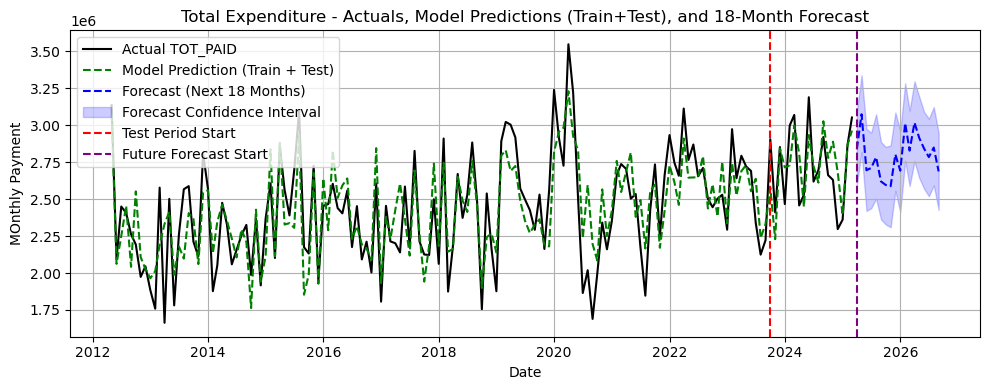

11:29:32 - cmdstanpy - INFO - Chain [1] start processing
11:29:32 - cmdstanpy - INFO - Chain [1] done processing



 Plotting Actual + Forecasts for Each Regressor (Only Necessary 6-Month Forecast)...


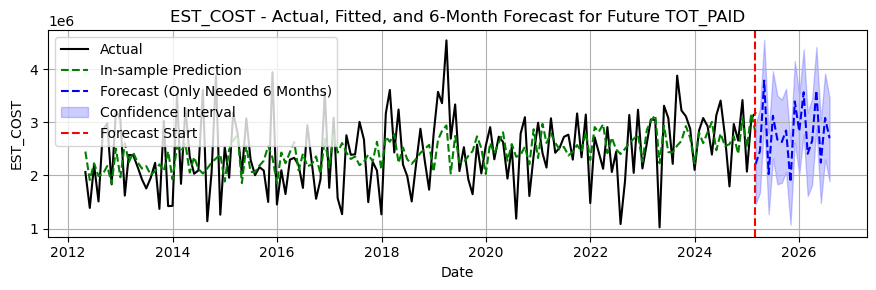

11:29:33 - cmdstanpy - INFO - Chain [1] start processing
11:29:33 - cmdstanpy - INFO - Chain [1] done processing


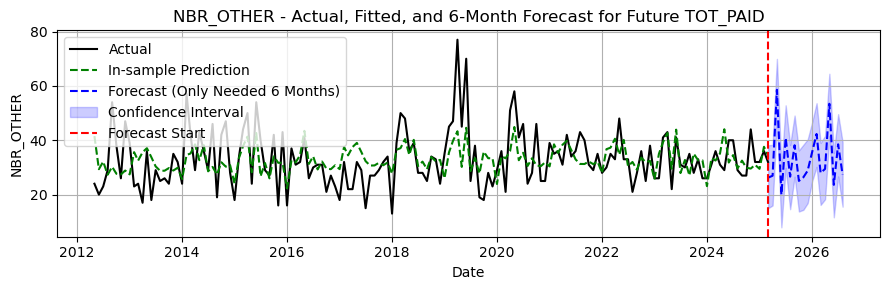

In [14]:
# --- Final Plot: Actuals + Model Prediction (Train + Test) + Forecast ---

forecast_train = prophet_model.predict(train[['ds', 'PC1', 'PC2']])
forecast_all = pd.concat([forecast_train[['ds', 'yhat']], forecast_test[['ds', 'yhat']]], ignore_index=True)
forecast_all = forecast_all.sort_values('ds').reset_index(drop=True)

plt.figure(figsize=(10, 4))

plt.plot(df_model['ds'], df_model['y'], label='Actual TOT_PAID', color='black')
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Model Prediction (Train + Test)', color='green', linestyle='--')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast (Next 18 Months)', color='blue', linestyle='--')

plt.fill_between(future_forecast['ds'],
                 future_forecast['yhat_lower'],
                 future_forecast['yhat_upper'],
                 color='blue', alpha=0.2, label='Forecast Confidence Interval')

plt.axvline(x=test['ds'].min(), color='red', linestyle='dashed', label='Test Period Start')
plt.axvline(x=future_forecast['ds'].min(), color='purple', linestyle='dashed', label='Future Forecast Start')

plt.title("Total Expenditure - Actuals, Model Predictions (Train+Test), and 18-Month Forecast")
plt.xlabel("Date")
plt.ylabel("MOnthly Payment")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Plot Each Regressor: Actual + In-sample Fit + 6-Month Forecast ---
print("\n Plotting Actual + Forecasts for Each Regressor (Only Necessary 6-Month Forecast)...")

for reg in regressors:
    df_reg = df_model[['ds', reg]].rename(columns={reg: 'y'})
    reg_model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.2)
    reg_model.fit(df_reg)

    # Only forecast 6 + lag months (e.g., 18 months if lag=12)
    future_dates = reg_model.make_future_dataframe(periods=lag + 6, freq='MS')
    forecast = reg_model.predict(future_dates)

    plt.figure(figsize=(9, 3))
    plt.plot(df_reg['ds'], df_reg['y'], color='black', label='Actual')

    fitted = forecast[forecast['ds'].isin(df_reg['ds'])]
    plt.plot(fitted['ds'], fitted['yhat'], color='green', linestyle='--', label='In-sample Prediction')

    forecast_future = forecast[forecast['ds'] > df_reg['ds'].max()]
    plt.plot(forecast_future['ds'], forecast_future['yhat'], color='blue', linestyle='--', label='Forecast (Only Needed 6 Months)')

    plt.fill_between(forecast_future['ds'], 
                     forecast_future['yhat_lower'], 
                     forecast_future['yhat_upper'], 
                     color='blue', alpha=0.2, label='Confidence Interval')

    plt.axvline(x=df_reg['ds'].max(), color='red', linestyle='dashed', label='Forecast Start')
    plt.title(f"{reg} - Actual, Fitted, and 6-Month Forecast for Future TOT_PAID")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
